## **QBIO 401 Final Project**

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.manifold import TSNE
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier as RF, GradientBoostingClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split,RepeatedKFold,StratifiedShuffleSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from model import Selection
%matplotlib inline
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
X_train = pd.read_excel('Xtrain.xlsx',index_col=0)
y_train = pd.read_excel('ytrain.xlsx',index_col=0)
X_test = pd.read_excel('Xtest.xlsx',index_col=0)
y_test = pd.read_excel('ytest.xlsx',index_col=0)
X_train.drop(['sample_id'],axis=1,inplace=True)
X_test.drop(['sample_id'],axis=1,inplace=True)

X_external = pd.read_excel('Xexternal_test.xlsx', index_col=0)
y_external = pd.read_excel('yexternal_test.xlsx', index_col=0)
X_external.drop(['sample_id'], axis=1, inplace=True)
y_external = y_external.reset_index(drop=True)

selected_features = ['Succinate_neg-079', 'Uridine_neg-088', 'Lactic acid_neg-055', 'S-Adenosyl-methionine_pos-139', 'Pyroglutamic acid_neg-072', '2-Aminooctanoic acid_pos-006', 'Neopterin_pos-117', 'N-Acetyl-D-glucosamine 6-phosphate_neg-061', 'Serotonin_pos-142', 'NMN_pos-162']
X_train_10dm = X_train[selected_features]
X_test_10dm = X_test[selected_features]
X_external_10dm = X_external[selected_features]

# *Visualizing Data Balance* #

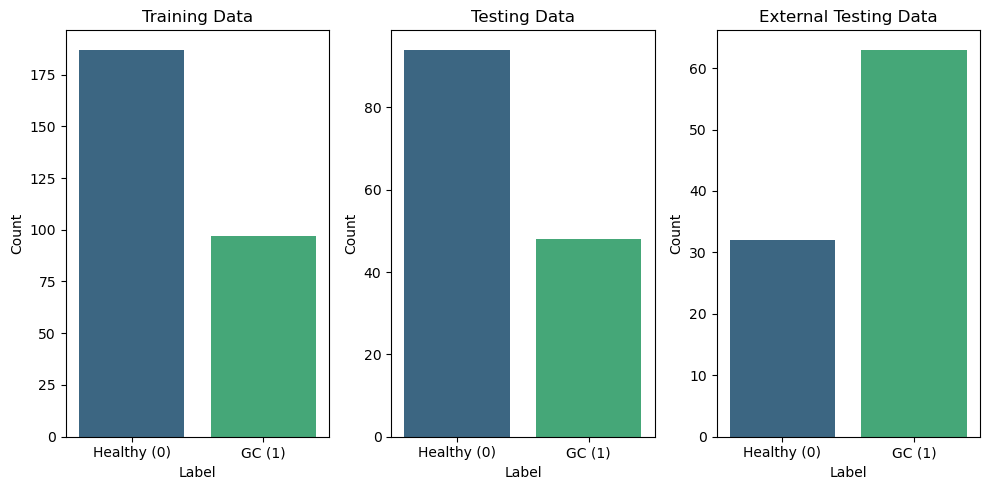

In [3]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,5))

sns.countplot(x='state', data=y_train, ax=ax[0], palette='viridis')
ax[0].set_title('Training Data')
ax[0].set_xlabel('Label')
ax[0].set_ylabel('Count')
ax[0].set_xticklabels(['Healthy (0)', 'GC (1)'])

sns.countplot(x='state', data=y_test, ax=ax[1], palette='viridis')
ax[1].set_title('Testing Data')
ax[1].set_xlabel('Label')
ax[1].set_ylabel('Count')
ax[1].set_xticklabels(['Healthy (0)', 'GC (1)'])

sns.countplot(x='state', data=y_external, ax=ax[2], palette='viridis')
ax[2].set_title('External Testing Data')
ax[2].set_xlabel('Label')
ax[2].set_ylabel('Count')
ax[2].set_xticklabels(['Healthy (0)', 'GC (1)'])

plt.tight_layout()
plt.show()

# *Heatmap of Top 10 Metabolites* #

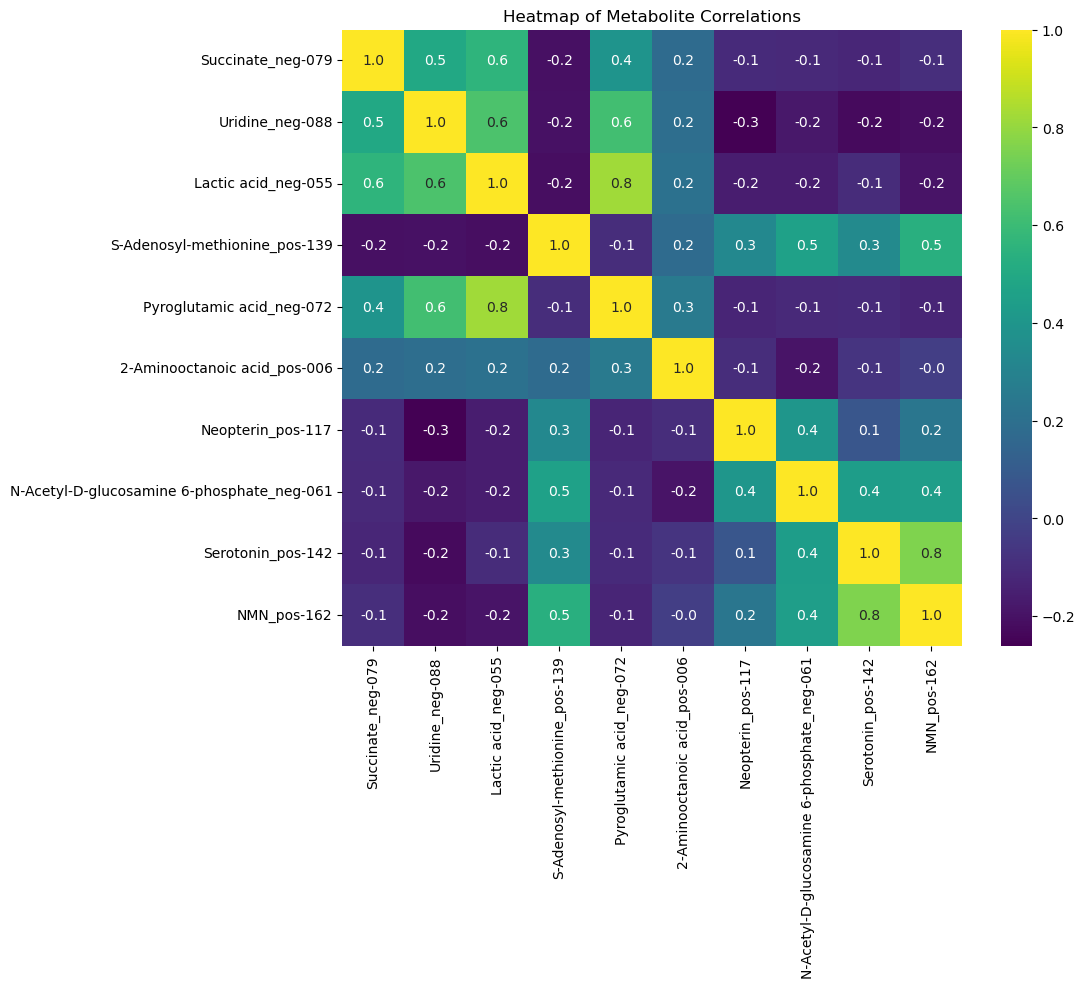

In [4]:
plt.figure(figsize=(10, 8))  # You can adjust the size as needed
sns.heatmap(X_test_10dm.corr(), annot=True, fmt=".1f", cmap='viridis')
plt.title('Heatmap of Metabolite Correlations')
plt.show()

# *Clustering Visualizations* #

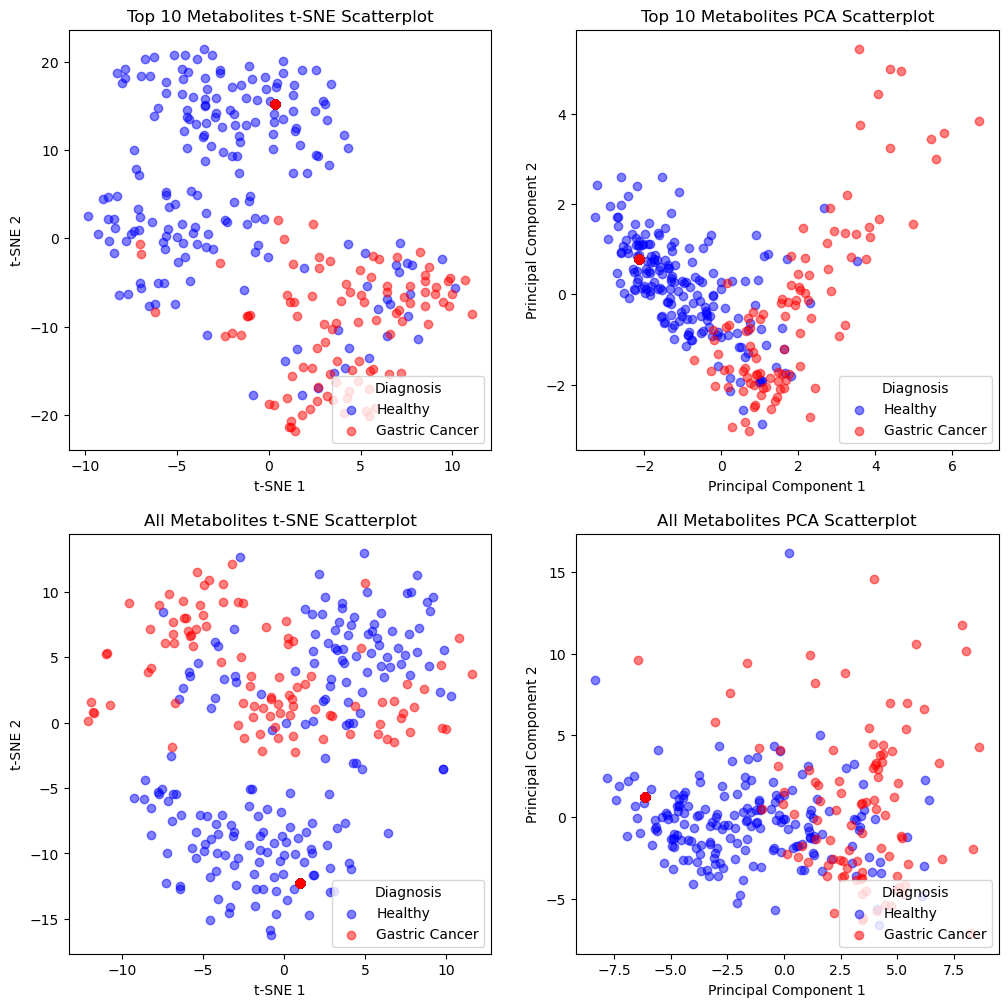

In [5]:
scaler = StandardScaler()
X_scaled_10dm = scaler.fit_transform(X_train_10dm)
X_scaled = scaler.fit_transform(X_train)

tsne = TSNE(n_components=2, random_state=12306)
X_tsne_10dm = tsne.fit_transform(X_scaled_10dm)
X_tsne = tsne.fit_transform(X_scaled)

pca = PCA(n_components=2)
X_pca_10dm = pca.fit_transform(X_scaled_10dm)
X_pca = pca.fit_transform(X_scaled)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,12))
colors = {0: 'blue', 1: 'red'} 
labels = {0: 'Healthy', 1: 'Gastric Cancer'}

# Plot each class separately
for class_label, color in colors.items():
    # Select indices corresponding to each class
    indices = np.where(y_train == class_label)
    ax[0,0].scatter(X_tsne_10dm[indices, 0], X_tsne_10dm[indices, 1], c=color, label=labels[class_label], alpha=0.5)
    ax[0,1].scatter(X_pca_10dm[indices, 0], X_pca_10dm[indices, 1], c=color, label=labels[class_label], alpha=0.5)
    ax[1,0].scatter(X_tsne[indices, 0], X_tsne[indices, 1], c=color, label=labels[class_label], alpha=0.5)
    ax[1,1].scatter(X_pca[indices, 0], X_pca[indices, 1], c=color, label=labels[class_label], alpha=0.5)

ax[0,0].set_title("Top 10 Metabolites t-SNE Scatterplot")
ax[0,0].set_xlabel('t-SNE 1')
ax[0,0].set_ylabel('t-SNE 2')
ax[0,0].legend(title='Diagnosis', loc='lower right')

ax[0,1].set_title("Top 10 Metabolites PCA Scatterplot")
ax[0,1].set_xlabel('Principal Component 1')
ax[0,1].set_ylabel('Principal Component 2')
ax[0,1].legend(title='Diagnosis', loc='lower right')

ax[1,0].set_title("All Metabolites t-SNE Scatterplot")
ax[1,0].set_xlabel('t-SNE 1')
ax[1,0].set_ylabel('t-SNE 2')
ax[1,0].legend(title='Diagnosis', loc='lower right')

ax[1,1].set_title("All Metabolites PCA Scatterplot")
ax[1,1].set_xlabel('Principal Component 1')
ax[1,1].set_ylabel('Principal Component 2')
ax[1,1].legend(title='Diagnosis', loc='lower right')

plt.show()

# *Replicating the 10-DM Model from the Paper* #


Testing Data Performance
test accuracy: 0.9154929577464789
roc score: 0.9709663120567376

External Testing Data Performance
external test accuracy: 0.8526315789473684
roc score: 0.9221230158730158


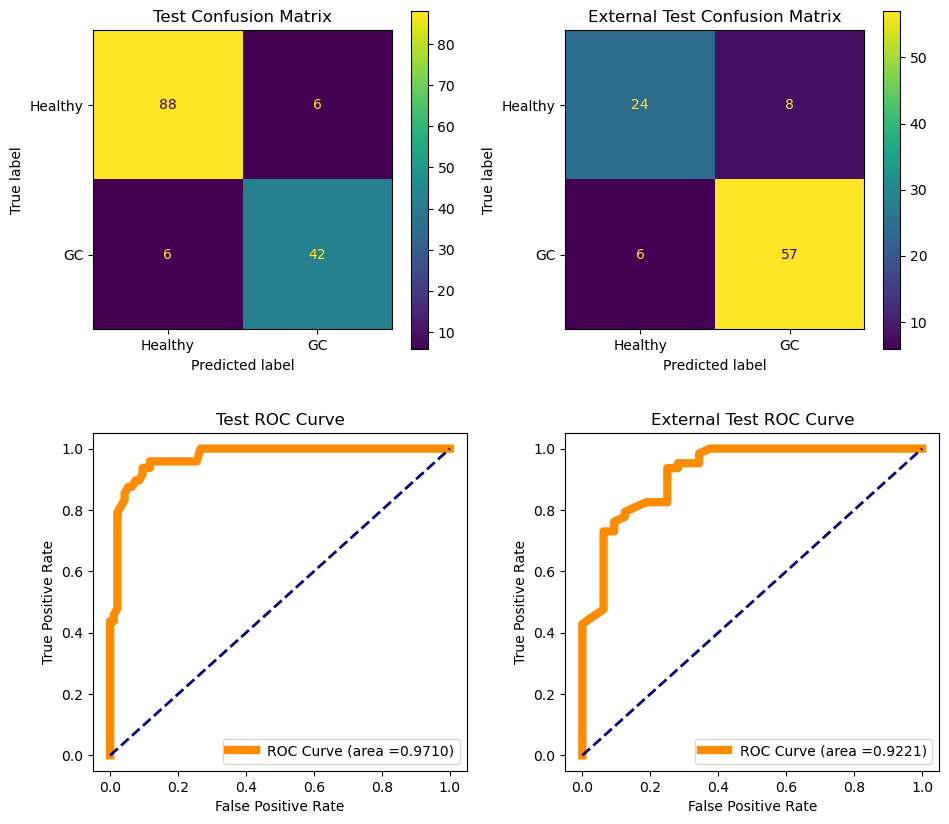

In [6]:
original_model = RF(n_estimators=100, random_state=12306)
original_model.fit(X_train_10dm, y_train.values.ravel())

y_pred = original_model.predict(X_test_10dm)
y_external_pred = original_model.predict(X_external_10dm)
y_pred_prob = original_model.predict_proba(X_test_10dm)
y_external_pred_prob = original_model.predict_proba(X_external_10dm)

test_accuracy = original_model.score(X=X_test_10dm, y=y_test)
test_roc_score = roc_auc_score(y_test, y_pred_prob[:,-1])
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:,-1])
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

external_test_accuracy = original_model.score(X=X_external_10dm, y=y_external)
external_test_roc_score = roc_auc_score(y_external, y_external_pred_prob[:,-1])
ext_fpr, ext_tpr, ext_thresholds = roc_curve(y_external, y_external_pred_prob[:,-1])
ext_conf_matrix = confusion_matrix(y_true=y_external, y_pred=y_external_pred)

print("\nTesting Data Performance")
print(f"test accuracy: {test_accuracy}\nroc score: {test_roc_score}")

print("\nExternal Testing Data Performance")
print(f"external test accuracy: {external_test_accuracy}\nroc score: {external_test_roc_score}")


fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,9))
fig.subplots_adjust(hspace=0.75)  # Increase the vertical space between rows
plt.rcParams["figure.autolayout"] = True
fig.tight_layout(pad=4.0)
labels = ["Healthy", "GC"]

ConfusionMatrixDisplay(conf_matrix, display_labels=labels).plot(ax=ax[0,0])
ConfusionMatrixDisplay(ext_conf_matrix, display_labels=labels).plot(ax=ax[0,1])
ax[0,0].set_title("Test Confusion Matrix")
ax[0,1].set_title("External Test Confusion Matrix")
ax[1,0].plot(fpr, tpr, color='darkorange', lw=6, label=f'ROC Curve (area ={test_roc_score:.4f})')
ax[1,0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax[1,0].set_title("Test ROC Curve")
ax[1,0].set_xlabel('False Positive Rate')
ax[1,0].set_ylabel('True Positive Rate')
ax[1,0].legend(loc='lower right')

ax[1,1].plot(ext_fpr, ext_tpr, color='darkorange', lw=6, label=f'ROC Curve (area ={external_test_roc_score:.4f})')
ax[1,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax[1,1].set_title("External Test ROC Curve")
ax[1,1].set_xlabel('False Positive Rate')
ax[1,1].set_ylabel('True Positive Rate')
ax[1,1].legend(loc='lower right')

plt.show()

# *Testing New Methods* #

In [7]:
def model_validation(X_train, X_test, X_external, y_train, y_test, y_external, n_repeats=10, model=RF(n_estimators=100,random_state=12306), class_weight=None, pca=False, n_pc=5):
        
    cv = RepeatedKFold(n_splits=5, n_repeats=n_repeats, random_state=10086)
    splitting = cv.split(X=X_train, y=y_train)

    kf_train_accuracies = []
    kf_test_accuracies = []
    kf_roc_scores = []
    confusion_matrices = []

    for train_index, test_index in splitting:
        
        X_subtrain = X_train.iloc[train_index, :]
        X_subtest = X_train.iloc[test_index, :]
        y_subtrain = y_train.iloc[train_index, :]
        y_subtest = y_train.iloc[test_index, :]

        scaler = StandardScaler()
        scaler.fit(X_subtrain)
        X_subtrain = scaler.transform(X_subtrain)
        X_subtest = scaler.transform(X_subtest)
        
        if pca == True:
            pca_model = PCA(n_components=n_pc)
            pca_model.fit(X_subtrain) 
            X_subtrain = pca_model.transform(X_subtrain)
            X_subtest = pca_model.transform(X_subtest)

        model = model
        model.fit(X=X_subtrain, y=y_subtrain.values.ravel())
        y_pred = model.predict(X_subtest)
        y_pred_prob = model.predict_proba(X_subtest)
        
        kf_test_accuracies.append(model.score(X=X_subtest, y=y_subtest))
        kf_roc_scores.append(roc_auc_score(y_subtest, y_pred_prob[:,-1]))
        confusion_matrices.append(confusion_matrix(y_true=y_subtest, y_pred=y_pred))

    kf_test_accuracy = np.mean(kf_test_accuracies)
    kf_roc_score = np.mean(kf_roc_scores)
    kf_fpr, kf_tpr, kf_thresholds = roc_curve(y_subtest, y_pred_prob[:,-1])
    kf_conf_matrix = np.mean(confusion_matrices, axis=0)

    print("K-Fold Cross Validation Performance")
    print(f"""k-fold test accuracy: {kf_test_accuracy}\nk-fold roc score: {kf_roc_score}""")

    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    X_external = scaler.transform(X_external)

    if pca == True:
        pca_model = PCA(n_components=n_pc)
        pca_model.fit(X_train) 
        X_train = pca_model.transform(X_train)
        X_test = pca_model.transform(X_test)
        X_external = pca_model.transform(X_external)
        
    model = model
    model.fit(X=X_train, y=y_train.values.ravel())
    y_pred = model.predict(X_test)
    y_external_pred = model.predict(X_external)
    y_pred_prob = model.predict_proba(X_test)
    y_external_pred_prob = model.predict_proba(X_external)
    
    test_accuracy = model.score(X=X_test, y=y_test)
    test_roc_score = roc_auc_score(y_test, y_pred_prob[:,-1])
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:,-1])
    conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

    external_test_accuracy = model.score(X=X_external, y=y_external)
    external_test_roc_score = roc_auc_score(y_external, y_external_pred_prob[:,-1])
    ext_fpr, ext_tpr, ext_thresholds = roc_curve(y_external, y_external_pred_prob[:,-1])
    ext_conf_matrix = confusion_matrix(y_true=y_external, y_pred=y_external_pred)

    print("\nTesting Data Performance")
    print(f"test accuracy: {test_accuracy}\nroc score: {test_roc_score}")

    print("\nExternal Testing Data Performance")
    print(f"external test accuracy: {external_test_accuracy}\nroc score: {external_test_roc_score}")

    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,9))
    fig.subplots_adjust(hspace=0.75)  # Increase the vertical space between rows
    plt.rcParams["figure.autolayout"] = True
    fig.tight_layout(pad=4.0)
    labels = ["Healthy", "GC"]
    
    # Plot the confusion matrices
    ConfusionMatrixDisplay(kf_conf_matrix, display_labels=labels).plot(ax=ax[0,0])
    ConfusionMatrixDisplay(conf_matrix, display_labels=labels).plot(ax=ax[0,1])
    ConfusionMatrixDisplay(ext_conf_matrix, display_labels=labels).plot(ax=ax[0,2])
    
    # Plot ROC curves
    ax[1,0].plot(kf_fpr, kf_tpr, color='darkorange', lw=6, label=f'ROC Curve (area ={kf_roc_score:.4f})')
    ax[1,0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax[1,0].set_title("K-Fold ROC Curve")
    ax[1,0].set_xlabel('False Positive Rate')
    ax[1,0].set_ylabel('True Positive Rate')
    ax[1,0].legend(loc='lower right')
    
    ax[1,1].plot(fpr, tpr, color='darkorange', lw=6, label=f'ROC Curve (area ={test_roc_score:.4f})')
    ax[1,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax[1,1].set_title("Test ROC Curve")
    ax[1,1].set_xlabel('False Positive Rate')
    ax[1,1].set_ylabel('True Positive Rate')
    ax[1,1].legend(loc='lower right')

    ax[1,2].plot(ext_fpr, ext_tpr, color='darkorange', lw=6, label=f'ROC Curve (area ={external_test_roc_score:.4f})')
    ax[1,2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax[1,2].set_title("External Test ROC Curve")
    ax[1,2].set_xlabel('False Positive Rate')
    ax[1,2].set_ylabel('True Positive Rate')
    ax[1,2].legend(loc='lower right')
    
    # Setting the titles for confusion matrices
    ax[0,0].set_title("K-Fold Confusion Matrix")
    ax[0,1].set_title("Test Confusion Matrix")
    ax[0,2].set_title("External Test Confusion Matrix")
    
    plt.show()  # Display the plots
        

# *Random Forest* #

In [8]:
param_grid = {
    'n_estimators': [50, 75, 100, 125, 150],
    'max_features': ['sqrt', 'log2', None],  
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 4]
}

rf = RF(random_state=12306)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train_10dm, y_train.values.ravel())
print("Best parameters:", grid_search.best_params_)

Fitting 5 folds for each of 810 candidates, totalling 4050 fits
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}


K-Fold Cross Validation Performance
k-fold test accuracy: 0.871140350877193
k-fold roc score: 0.9336102185521108

Testing Data Performance
test accuracy: 0.9225352112676056
roc score: 0.9697473404255319

External Testing Data Performance
external test accuracy: 0.8526315789473684
roc score: 0.9166666666666666


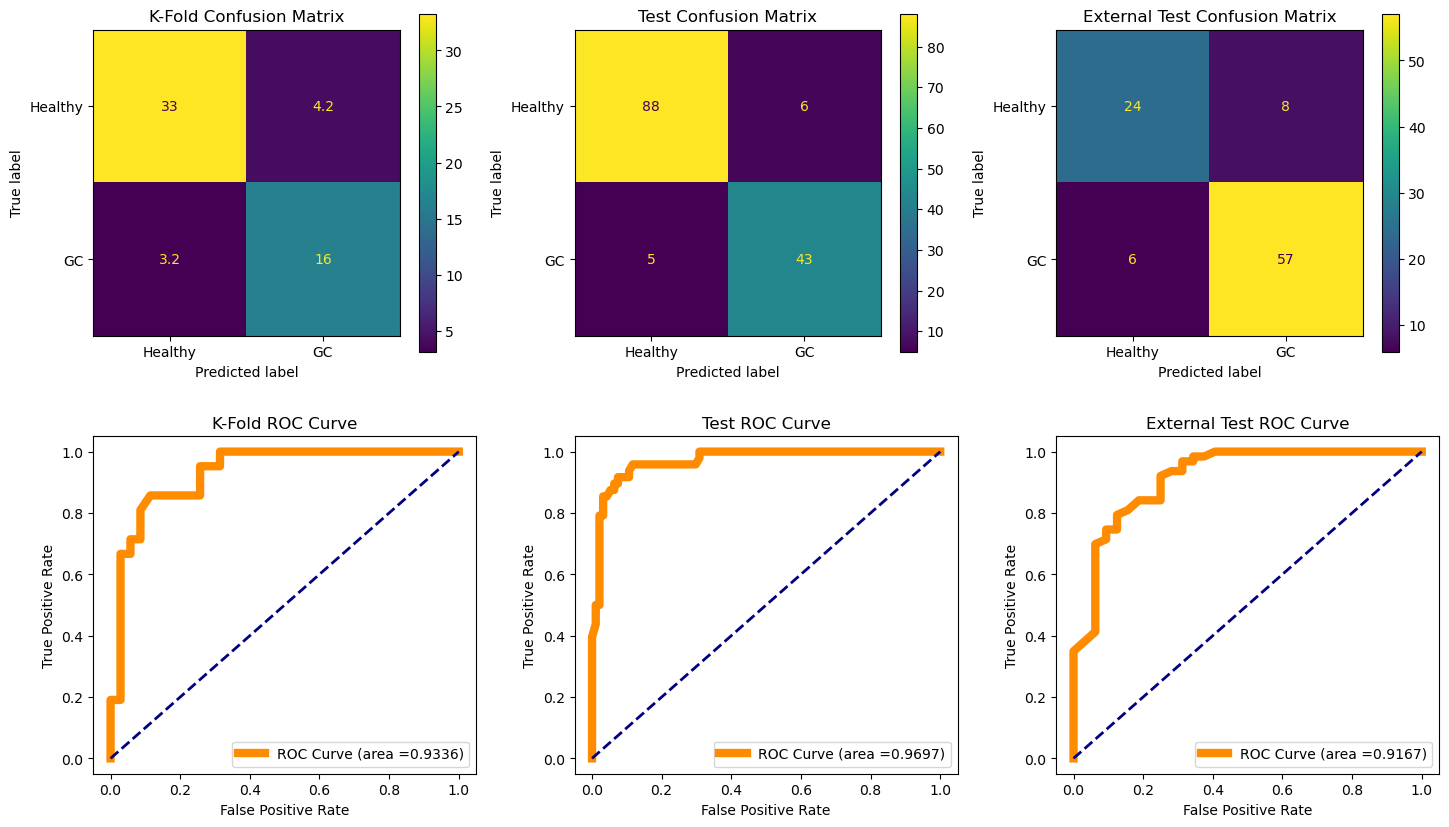

In [9]:
best_rf = RF(max_depth=None, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators=115, random_state=12306)
model_validation(X_train_10dm, X_test_10dm, X_external_10dm, y_train, y_test, y_external, model=best_rf, n_repeats=5)

# *Logistic Regression* #

In [10]:
param_grid = {
    'C': [0.001, 0.005, 0.01, 0.05],  # Regularization strength
    'solver': ['lbfgs', 'saga']  # Solvers
}

log_reg = LogisticRegression(max_iter=10000, class_weight={0:1, 1:0.9}, random_state=12306)
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train_10dm, y_train.values.ravel())
print("Best parameters:", grid_search.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters: {'C': 0.001, 'solver': 'lbfgs'}


K-Fold Cross Validation Performance
k-fold test accuracy: 0.8605513784461152
k-fold roc score: 0.9453262041113989

Testing Data Performance
test accuracy: 0.9154929577464789
roc score: 0.9618794326241135

External Testing Data Performance
external test accuracy: 0.8210526315789474
roc score: 0.8839285714285714


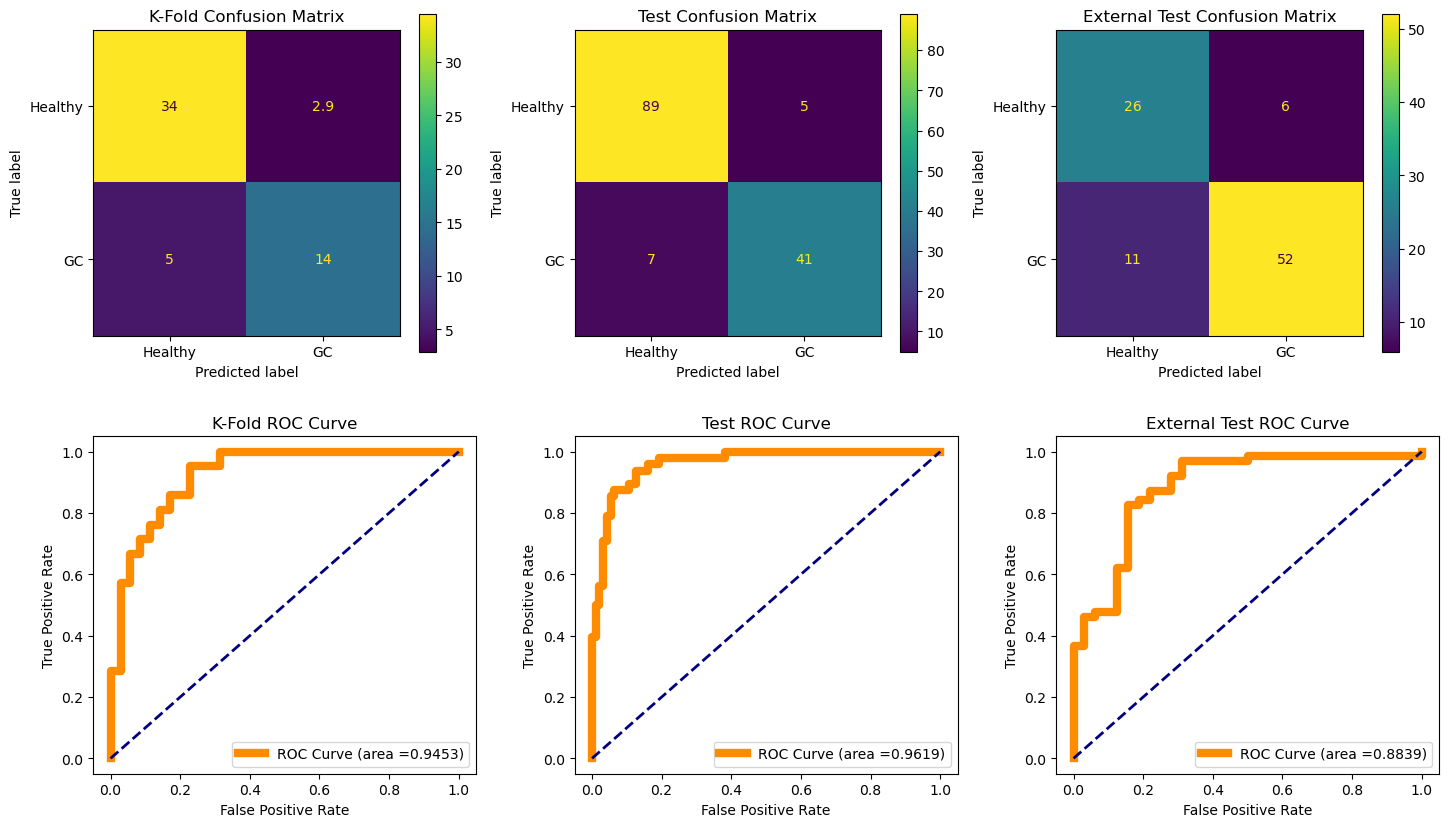

In [11]:
log_reg = LogisticRegression(C=0.0075, solver='lbfgs',class_weight={0:0.8, 1:1}, random_state=12306, max_iter=10000)
model_validation(X_train_10dm, X_test_10dm, X_external_10dm, y_train, y_test, y_external, model=log_reg, n_repeats=5)

In [12]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'solver': ['lbfgs', 'saga']  # Solvers
}

log_reg = LogisticRegression(max_iter=10000, class_weight={0:1, 1:0.9}, random_state=12306)
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
pca = PCA(n_components=20)
pca.fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)
grid_search.fit(X_train_pca, y_train.values.ravel())
print("Best parameters:", grid_search.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'C': 10, 'solver': 'saga'}


K-Fold Cross Validation Performance
k-fold test accuracy: 0.8548370927318296
k-fold roc score: 0.9218189512178651

Testing Data Performance
test accuracy: 0.8732394366197183
roc score: 0.9443705673758865

External Testing Data Performance
external test accuracy: 0.9368421052631579
roc score: 0.9747023809523809


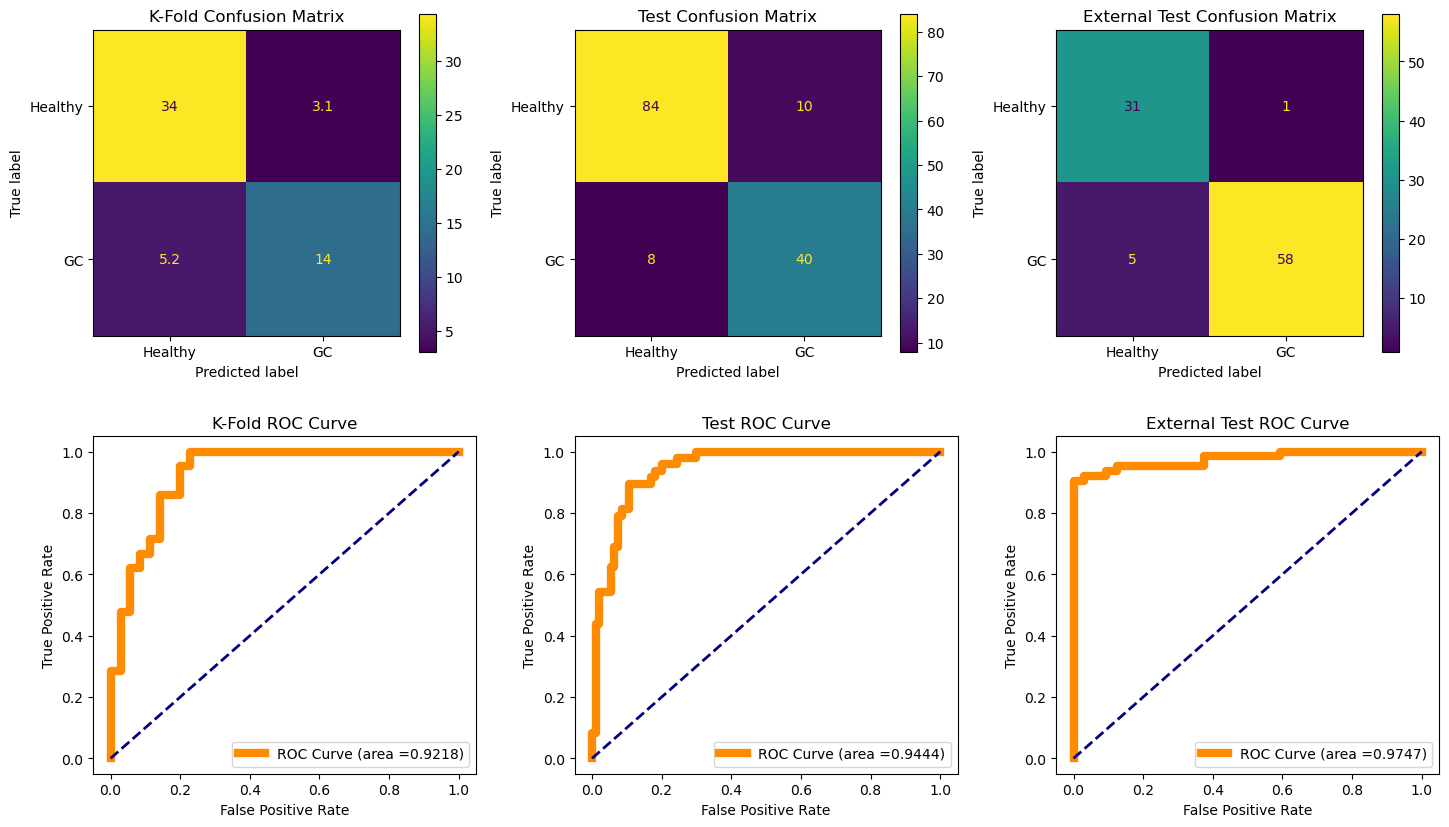

In [13]:
log_reg_pca = LogisticRegression(C=10, solver='saga',class_weight={0:1, 1:0.75}, random_state=12306, max_iter=10000)
model_validation(X_train, X_test, X_external, y_train, y_test, y_external, model=log_reg_pca, n_repeats=5, pca=True, n_pc=19)

# *Support Vector Machine* #

In [14]:
param_grid = {
    'C': [100, 200, 300, 400],  # Example C values
    'gamma': ['scale', 'auto', 0.1, 1, 10, 100],  # Example gamma values
    'kernel': ['rbf', 'poly', 'sigmoid']  # Example kernels
}

grid_search = GridSearchCV(SVC(class_weight={0:1, 1:0.9}, random_state=12306), param_grid, cv=5)
grid_search.fit(X_train_10dm, y_train.values.ravel())
print("Best parameters:", grid_search.best_params_)

Best parameters: {'C': 300, 'gamma': 'scale', 'kernel': 'poly'}


K-Fold Cross Validation Performance
k-fold test accuracy: 0.846516290726817
k-fold roc score: 0.9113487425636138

Testing Data Performance
test accuracy: 0.8873239436619719
roc score: 0.9465868794326241

External Testing Data Performance
external test accuracy: 0.6947368421052632
roc score: 0.8050595238095238


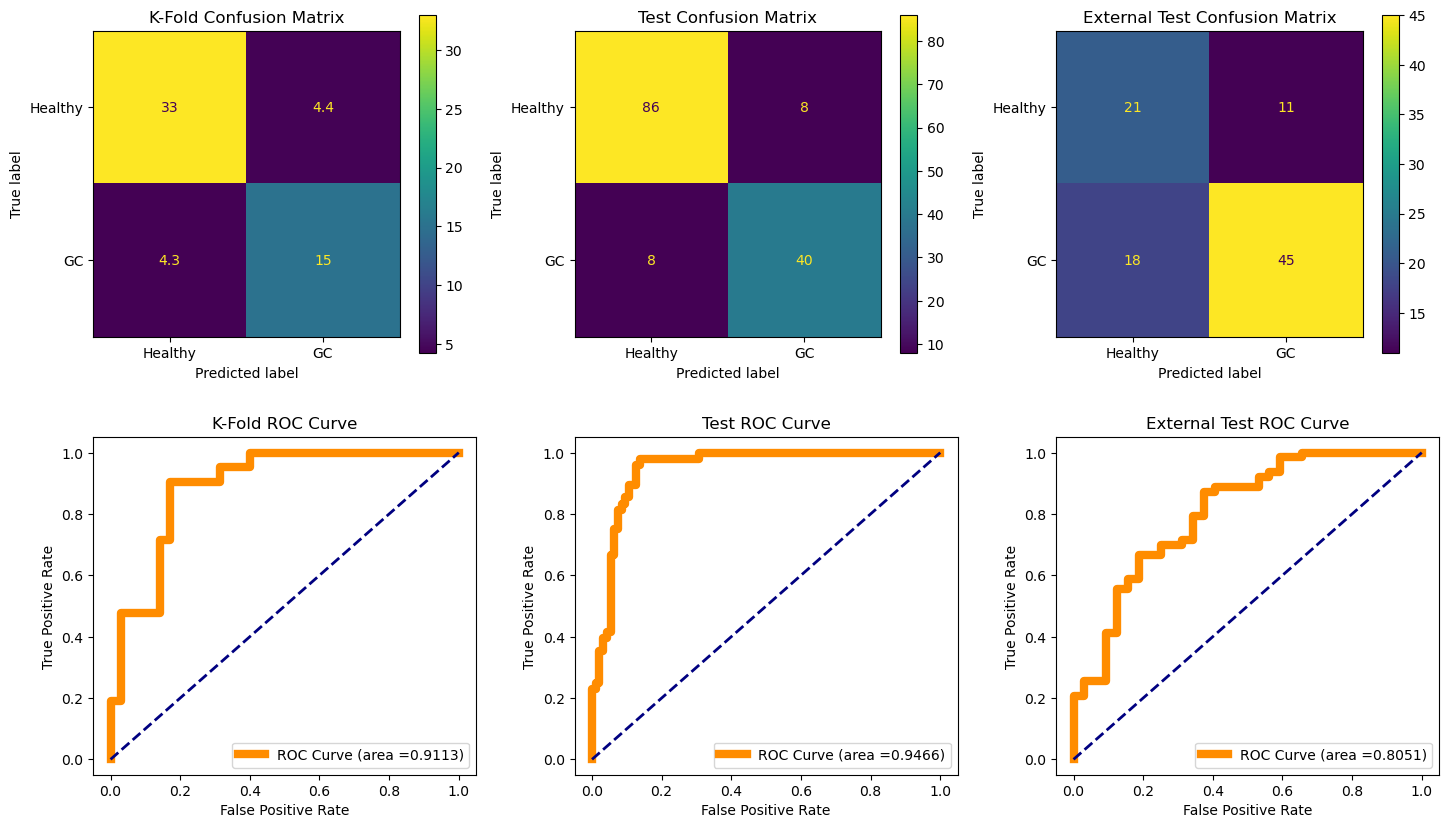

In [15]:
svm = SVC(kernel='rbf', C=300, gamma='scale', class_weight={0:1, 1:0.9}, random_state=12306, probability=True)
model_validation(X_train_10dm, X_test_10dm, X_external_10dm, y_train, y_test, y_external, model=svm, n_repeats=5)

In [16]:
param_grid = {
    'C': [25, 50, 75, 100],  # Example C values
    'gamma': ['scale', 'auto', 0.1, 1, 10, 100],  # Example gamma values
    'kernel': ['rbf', 'poly', 'sigmoid']  # Example kernels
}

grid_search = GridSearchCV(SVC(random_state=12306), param_grid, cv=5)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
pca = PCA(n_components=75)
pca.fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)
grid_search.fit(X_train_pca, y_train.values.ravel())
print("Best parameters:", grid_search.best_params_)

Best parameters: {'C': 25, 'gamma': 'scale', 'kernel': 'rbf'}


K-Fold Cross Validation Performance
k-fold test accuracy: 0.897205513784461
k-fold roc score: 0.9606626641822706

Testing Data Performance
test accuracy: 0.9366197183098591
roc score: 0.975177304964539

External Testing Data Performance
external test accuracy: 0.8210526315789474
roc score: 0.9290674603174603


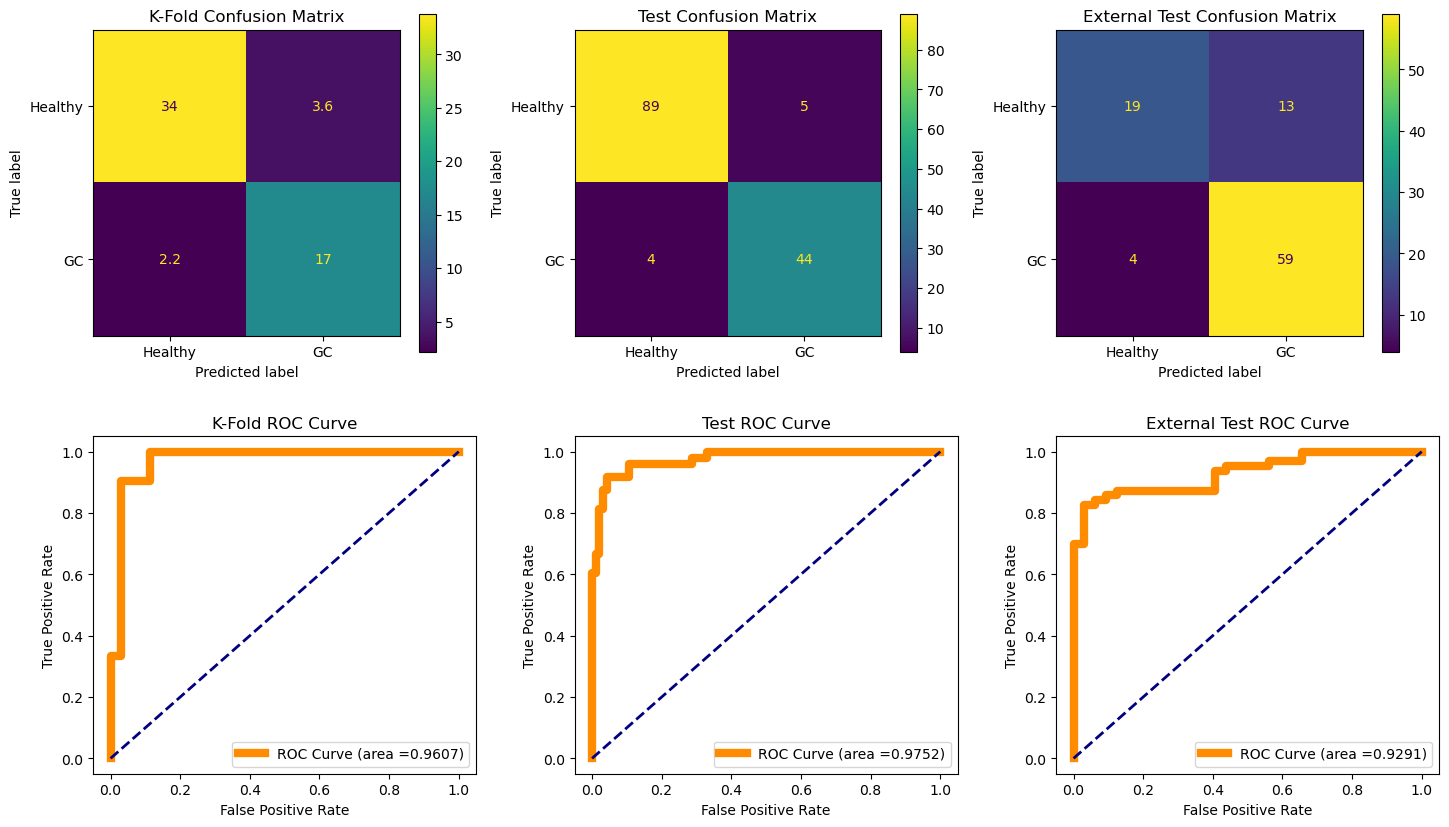

In [17]:
svm_pca = SVC(kernel='rbf', C=25, gamma='scale', random_state=12306, probability=True)
model_validation(X_train, X_test, X_external, y_train, y_test, y_external, model=svm_pca, n_repeats=5, pca=True, n_pc=75)

# *k-Nearest Neighbors* #

In [18]:
param_grid = {'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10]}
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_10dm, y_train.values.ravel())
print("Best parameters:", grid_search.best_params_)

Best parameters: {'n_neighbors': 3}


K-Fold Cross Validation Performance
k-fold test accuracy: 0.8605889724310778
k-fold roc score: 0.9019507611779616

Testing Data Performance
test accuracy: 0.8943661971830986
roc score: 0.9568927304964538

External Testing Data Performance
external test accuracy: 0.6842105263157895
roc score: 0.7738095238095238


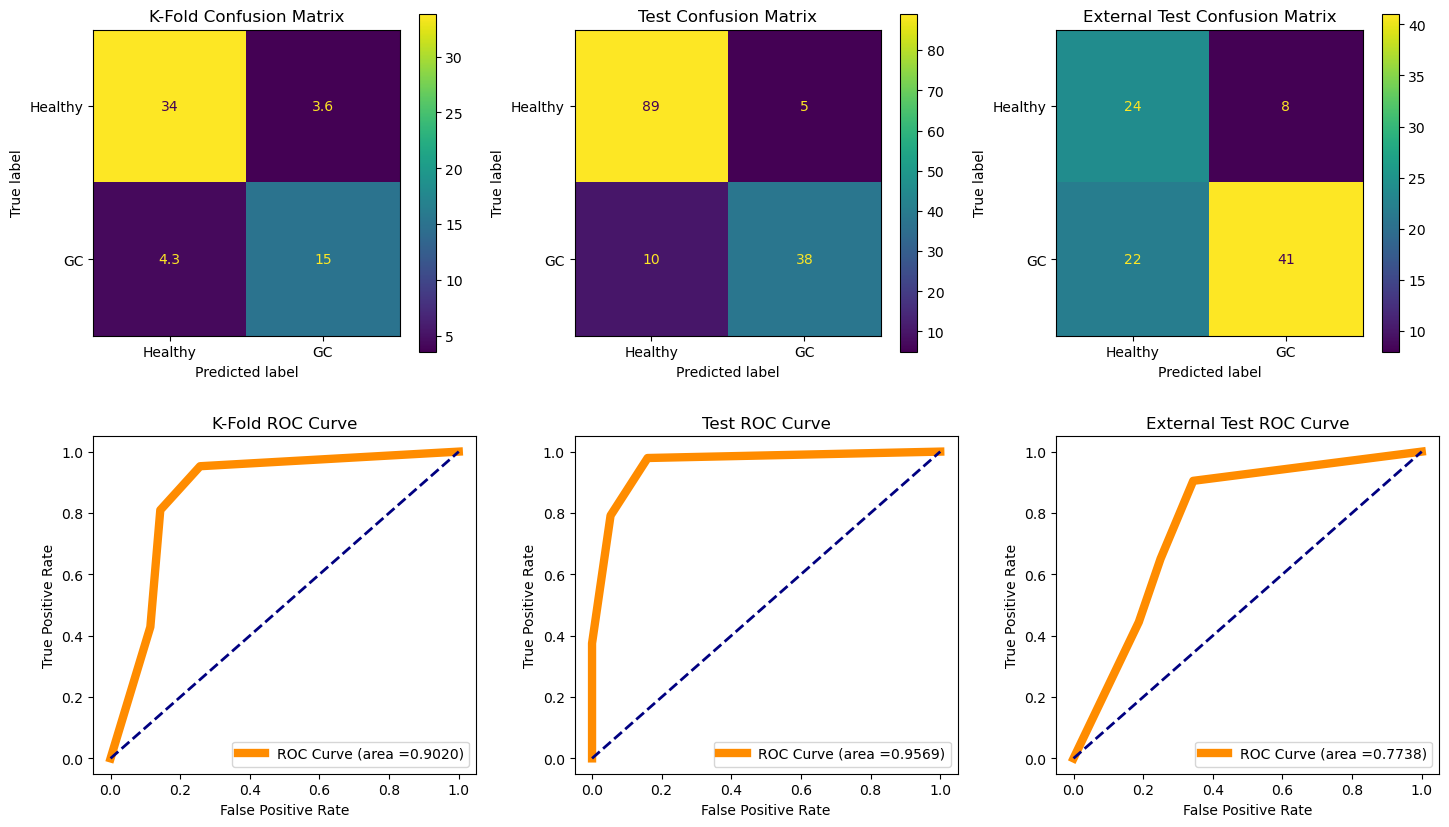

In [19]:
knn = KNeighborsClassifier(n_neighbors=3)
model_validation(X_train_10dm, X_test_10dm, X_external_10dm, y_train, y_test, y_external, model=knn, n_repeats=5)

# *Gradient Boosting* #

In [20]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2]
}

GB = GradientBoostingClassifier(random_state=12306)
grid_search = GridSearchCV(estimator=GB, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train_10dm, y_train.values.ravel())
print("Best parameters:", grid_search.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}


K-Fold Cross Validation Performance
k-fold test accuracy: 0.8521428571428572
k-fold roc score: 0.923210259495572

Testing Data Performance
test accuracy: 0.8873239436619719
roc score: 0.9570035460992908

External Testing Data Performance
external test accuracy: 0.8
roc score: 0.8953373015873016


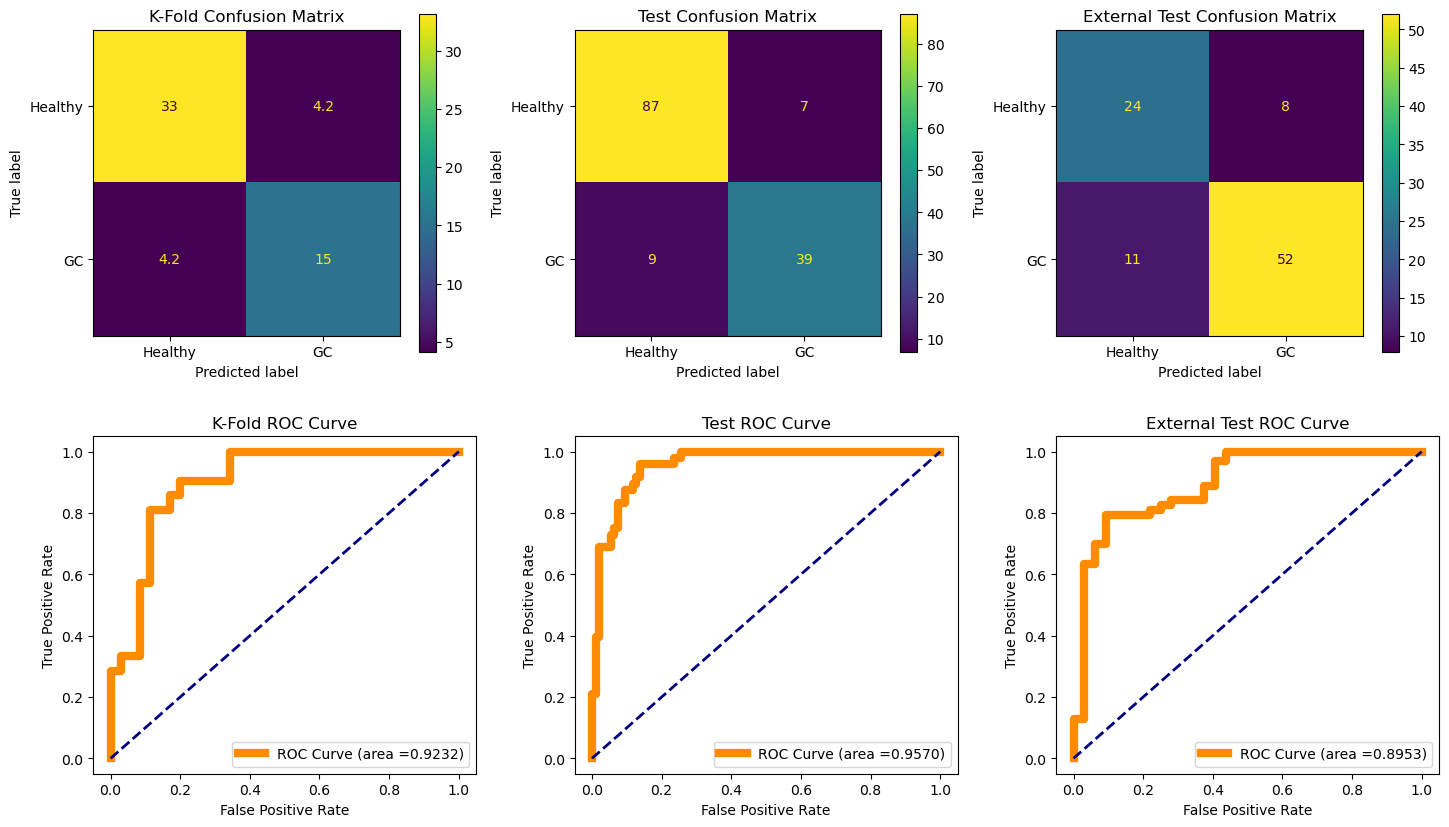

In [21]:
GB = GradientBoostingClassifier(learning_rate=0.1, max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=200, random_state=12306)
model_validation(X_train_10dm, X_test_10dm, X_external_10dm, y_train, y_test, y_external, model=GB, n_repeats=5)

# *Deep Learning Approach* #

In [22]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l1, l2, l1_l2
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
from keras.callbacks import EarlyStopping
from keras.models import load_model
import random

random.seed(12306)
np.random.seed(12306)
tf.random.set_seed(12306)

# *Deep Learning on Original Data Split* #

In [23]:
scaler = StandardScaler()
scaler.fit(X_train_10dm)
X_train_10dm_scaled = scaler.transform(X_train_10dm)
X_test_10dm_scaled = scaler.transform(X_test_10dm)
X_external_10dm_scaled = scaler.transform(X_external_10dm)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_external_scaled = scaler.transform(X_external)

In [24]:
model_10dm = None
model_10dm = Sequential()

model_10dm.add(Input(shape=(10,)))

model_10dm.add(Dense(2000))
model_10dm.add(Activation('relu'))
model_10dm.add(Dropout(0.5))

model_10dm.add(Dense(2000))
model_10dm.add(Activation('relu'))

model_10dm.add(Dense(1))
model_10dm.add(Activation('sigmoid'))

model_10dm.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0005), metrics=['accuracy'])
model_10dm.summary()

history = model_10dm.fit(X_train_10dm_scaled, y_train, validation_split=0.2, epochs=200, batch_size=15)
test_loss, test_acc = model_10dm.evaluate(X_test_10dm_scaled, y_test)
ext_loss, ext_acc = model_10dm.evaluate(X_external_10dm_scaled, y_external)
print(f"Test Accuracy: {test_acc}")
print(f"External Accuracy: {ext_acc}")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 2000)           │        22,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2000)           │     4,002,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         2,001 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,026,001 (15.36 MB)

 Trainable params: 4,026,001 (15.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.7149 - loss: 0.4672 - val_accuracy: 0.8246 - val_loss: 0.3553
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8824 - loss: 0.2416 - val_accuracy: 0.8421 - val_loss: 0.3261
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8939 - loss: 0.2021 - val_accuracy: 0.8246 - val_loss: 0.3444
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9001 - loss: 0.1985 - val_accuracy: 0.8772 - val_loss: 0.3306
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9179 - loss: 0.1799 - val_accuracy: 0.8246 - val_loss: 0.3608
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9102 - loss: 0.1763 - val_accuracy: 0.8421 - val_loss: 0.3992
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9300 - loss: 0.1531 - val_accuracy: 0.8246 - val_loss: 0.4031
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9604 - loss: 0.1447 - val_accuracy: 0.

In [33]:
n_pc = 60
model_pc = None
model_pc = Sequential()

model_pc.add(Input(shape=(n_pc,)))

model_pc.add(Dense(1000))
model_pc.add(Activation('relu'))

model_pc.add(Dense(1200))
model_pc.add(Activation('relu'))

model_pc.add(Dense(1))
model_pc.add(Activation('sigmoid'))

model_pc.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
model_pc.summary()

pca_model = PCA(n_components=n_pc)
pca_model.fit(X_train_scaled) 
X_train_pca = pca_model.transform(X_train_scaled)
X_test_pca = pca_model.transform(X_test_scaled)
X_external_pca = pca_model.transform(X_external_scaled)

history = model_pc.fit(X_train_pca, y_train, validation_split=0.1, epochs=200, batch_size=30)
test_loss, test_acc = model_pc.evaluate(X_test_pca, y_test)
ext_loss, ext_acc = model_pc.evaluate(X_external_pca, y_external)

test_probs = model_pc.predict(X_test_pca)
test_auc = roc_auc_score(y_test, test_probs)

ext_probs = model_pc.predict(X_external_pca)
ext_auc = roc_auc_score(y_external, ext_probs)

print(f"Test Accuracy: {test_acc}")
print(f"Test AUC: {test_auc}")
print(f"External Test Accuracy: {ext_acc}")
print(f"External Test AUC: {ext_auc}")

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_21 (Dense)                │ (None, 1000)           │        61,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_21 (Activation)      │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1200)           │     1,201,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_22 (Activation)      │ (None, 1200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │         1,201 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_23 (Activation)      │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,263,401 (4.82 MB)

 Trainable params: 1,263,401 (4.82 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7750 - loss: 0.4790 - val_accuracy: 0.8966 - val_loss: 0.4395
Epoch 2/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9732 - loss: 0.0964 - val_accuracy: 0.8276 - val_loss: 0.6408
Epoch 3/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9776 - loss: 0.0471 - val_accuracy: 0.8276 - val_loss: 0.6516
Epoch 4/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9935 - loss: 0.0268 - val_accuracy: 0.7931 - val_loss: 0.8896
Epoch 5/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0100 - val_accuracy: 0.8276 - val_loss: 0.9126
Epoch 6/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0049 - val_accuracy: 0.7931 - val_loss: 0.9871
Epoch 7/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0026 - val_accuracy: 0.7931 - val_loss: 1.0632
Epoch 8/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.7931 - val_loss:

In [34]:
# model_pc.save('GC_Classifier_60pc_original_training.keras')

# *Deep Learning on New Data Split* #

In [35]:
X_external = pd.read_excel('Xexternal_test.xlsx')
y_external = pd.read_excel('yexternal_test.xlsx')
y_external = pd.DataFrame(y_external['state'])
X_external.drop(columns=['sample_id', 'Unnamed: 0'], inplace=True)
X_train_new = pd.concat([X_train, X_external], ignore_index=True)
y_train_new = pd.concat([y_train, y_external], ignore_index=True)
X_train_new_10dm = X_train_new[selected_features]

scaler_all = StandardScaler()
scaler_all.fit(X_train_new)
X_train_new_scaled = scaler_all.transform(X_train_new)
X_test_scaled = scaler_all.transform(X_test)

scaler_10dm = StandardScaler()
scaler_10dm.fit(X_train_new_10dm)
X_train_new_10dm_scaled = scaler_10dm.transform(X_train_new_10dm)
X_test_10dm_scaled = scaler_10dm.transform(X_test_10dm)

y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)
y_train_new_encoded = to_categorical(y_train_new)

In [36]:
model_10dm = None
model_10dm = Sequential()

model_10dm.add(Input(shape=(10,)))

model_10dm.add(Dense(200))
model_10dm.add(Activation('relu'))

model_10dm.add(Dense(700))
model_10dm.add(Activation('relu'))

model_10dm.add(Dense(200))
model_10dm.add(Activation('relu'))

model_10dm.add(Dense(1))
model_10dm.add(Activation('sigmoid'))

model_10dm.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0005), metrics=['accuracy'])
model_10dm.summary()

history = model_10dm.fit(X_train_new_10dm_scaled, y_train_new, validation_split=0.2, epochs=300, batch_size=40)
test_loss, test_acc = model_10dm.evaluate(X_test_10dm_scaled, y_test)
print(f"Test Accuracy: {test_acc}")

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 200)            │         2,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_24 (Activation)      │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 700)            │       140,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_25 (Activation)      │ (None, 700)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 200)            │       140,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_26 (Activation)      │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │           201 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_27 (Activation)      │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 283,301 (1.08 MB)

 Trainable params: 283,301 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6658 - loss: 0.6180 - val_accuracy: 0.8289 - val_loss: 0.4636
Epoch 2/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8861 - loss: 0.3469 - val_accuracy: 0.8553 - val_loss: 0.4918
Epoch 3/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8753 - loss: 0.2755 - val_accuracy: 0.8553 - val_loss: 0.5791
Epoch 4/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8873 - loss: 0.2524 - val_accuracy: 0.8684 - val_loss: 0.6275
Epoch 5/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9042 - loss: 0.2335 - val_accuracy: 0.8684 - val_loss: 0.6570
Epoch 6/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9046 - loss: 0.2219 - val_accuracy: 0.8816 - val_loss: 0.6832
Epoch 7/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9083 - loss: 0.2115 - val_accuracy: 0.8816 - val_loss: 0.7145
Epoch 8/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9145 - loss: 0.1996 - val_accuracy: 0.8816 - val_loss: 0.74

In [37]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_all = None
model_all = Sequential()

model_all.add(Input(shape=(147,)))

model_all.add(Dense(600))
model_all.add(Activation('relu'))

model_all.add(Dense(1))
model_all.add(Activation('sigmoid'))

model_all.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
model_all.summary()

history = model_all.fit(X_train_new_scaled, y_train_new, validation_split=0.2, epochs=200, batch_size=30)
test_loss, test_acc = model_all.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {test_acc}")

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_28 (Dense)                │ (None, 600)            │        88,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_28 (Activation)      │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │           601 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_29 (Activation)      │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89,401 (349.22 KB)

 Trainable params: 89,401 (349.22 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6818 - loss: 0.5440 - val_accuracy: 0.9605 - val_loss: 0.2075
Epoch 2/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9471 - loss: 0.1733 - val_accuracy: 0.9474 - val_loss: 0.1561
Epoch 3/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9642 - loss: 0.1115 - val_accuracy: 0.9605 - val_loss: 0.1408
Epoch 4/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9888 - loss: 0.0761 - val_accuracy: 0.9605 - val_loss: 0.1331
Epoch 5/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9981 - loss: 0.0541 - val_accuracy: 0.9737 - val_loss: 0.1325
Epoch 6/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0405 - val_accuracy: 0.9737 - val_loss: 0.1319
Epoch 7/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0312 - val_accuracy: 0.9605 - val_loss: 0.1305
Epoch 8/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0247 - val_accuracy: 0.9605 -

In [38]:
n_pc = 60
pca_model = PCA(n_components=n_pc)
pca_model.fit(X_train_new_scaled) 
X_train_pca = pca_model.transform(X_train_new_scaled)
X_test_pca = pca_model.transform(X_test_scaled)

In [39]:
model_pc = None
model_pc = Sequential()

model_pc.add(Input(shape=(n_pc,)))

model_pc.add(Dense(1000))
model_pc.add(Activation('relu'))

model_pc.add(Dense(1))
model_pc.add(Activation('sigmoid'))

model_pc.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
model_pc.summary()

history = model_pc.fit(X_train_pca, y_train_new, validation_split=0.2, epochs=200, batch_size=50)
test_loss, test_acc = model_pc.evaluate(X_test_pca, y_test)
print(f"Test Accuracy: {test_acc}")

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_30 (Dense)                │ (None, 1000)           │        61,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_30 (Activation)      │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │         1,001 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_31 (Activation)      │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,001 (242.19 KB)

 Trainable params: 62,001 (242.19 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.7374 - loss: 0.5843 - val_accuracy: 0.7763 - val_loss: 0.5208
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9350 - loss: 0.2738 - val_accuracy: 0.8816 - val_loss: 0.3700
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9419 - loss: 0.1913 - val_accuracy: 0.9079 - val_loss: 0.2973
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9531 - loss: 0.1519 - val_accuracy: 0.9079 - val_loss: 0.2619
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9581 - loss: 0.1251 - val_accuracy: 0.9211 - val_loss: 0.2427
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9727 - loss: 0.1036 - val_accuracy: 0.9342 - val_loss: 0.2309
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9827 - loss: 0.0859 - val_accuracy: 0.9211 - val_loss: 0.2228
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9903 - loss: 0.0717 - val_accuracy: 0.9342 - val_loss: 0.2174

In [40]:
# model_10dm.save('GC_Classifier_10dm.keras') # Uncomment these save lines to save better performing models. 

In [41]:
# model_all.save('GC_Classifier_all_metabolites.keras')

In [42]:
# model_pc.save('GC_Classifier_60pc.keras')

# *Evaluating Neural Network Performance* #

In [43]:
def deep_model_validation(model_file, X_test, y_test):
    model = load_model(model_file)
    model.summary()
    test_loss, test_acc = model.evaluate(X_test, y_test)
    
    # Assuming X_test_10dm is preprocessed appropriately for the model
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob >= 0.5).astype(int)

    test_roc_score = roc_auc_score(y_test, y_pred_prob[:,-1])
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:,-1])
    conf_matrix = confusion_matrix(y_test, y_pred)

    print("\nTesting Data Performance")
    print(f"test accuracy: {test_acc}\nroc score: {test_roc_score}")    

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,7))
    fig.subplots_adjust(hspace=0.75)  # Increase the vertical space between rows
    plt.rcParams["figure.autolayout"] = True
    fig.tight_layout(pad=4.0)
    labels = ["Healthy", "GC"]
    
    # Plot the confusion matrices
    ConfusionMatrixDisplay(conf_matrix, display_labels=labels).plot(ax=ax[0])
    ax[0].set_title("Neural Network Confusion Matrix")

    
    # Plot ROC curves
    ax[1].plot(fpr, tpr, color='darkorange', lw=6, label=f'ROC Curve (area ={test_roc_score:.4f})')
    ax[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax[1].set_title("Neural Network ROC Curve")
    ax[1].set_xlabel('False Positive Rate')
    ax[1].set_ylabel('True Positive Rate')
    ax[1].legend(loc='lower right')

    plt.show()

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_67 (Dense)                │ (None, 1000)           │        61,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_67 (Activation)      │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 1200)           │     1,201,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_68 (Activation)      │ (None, 1200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 1)              │         1,201 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_69 (Activation)      │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,790,205 (14.46 MB)

 Trainable params: 1,263,401 (4.82 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,526,804 (9.64 MB)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9460 - loss: 0.2928      
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 

Testing Data Performance
test accuracy: 0.922535240650177
roc score: 0.97052304964539


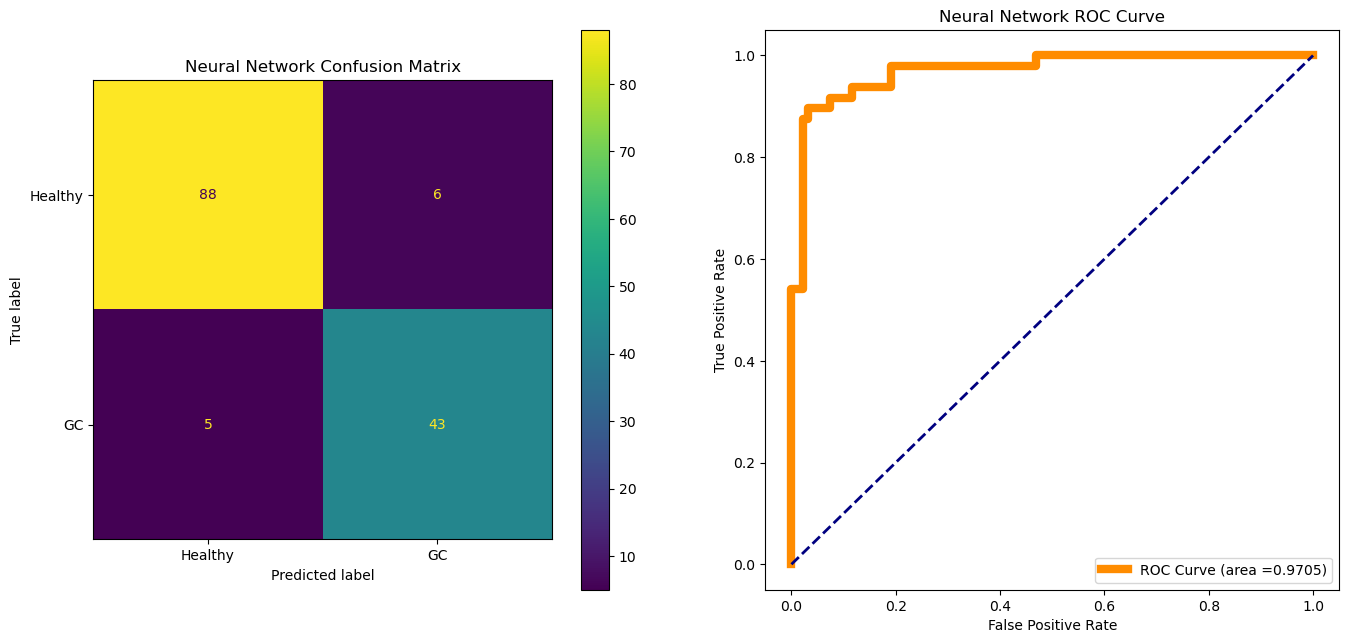

In [66]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_external_scaled = scaler.transform(X_external)
pca_model = PCA(n_components=60)
pca_model.fit(X_train_scaled) 
X_test_pca = pca_model.transform(X_test_scaled)
X_external_pca = pca_model.transform(X_external_scaled)
deep_model_validation('GC_Classifier_60pc_original_training.keras', X_test_pca, y_test)

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_67 (Dense)                │ (None, 1000)           │        61,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_67 (Activation)      │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 1200)           │     1,201,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_68 (Activation)      │ (None, 1200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 1)              │         1,201 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_69 (Activation)      │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,790,205 (14.46 MB)

 Trainable params: 1,263,401 (4.82 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,526,804 (9.64 MB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8771 - loss: 1.2787  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

Testing Data Performance
test accuracy: 0.8947368264198303
roc score: 0.9444444444444444


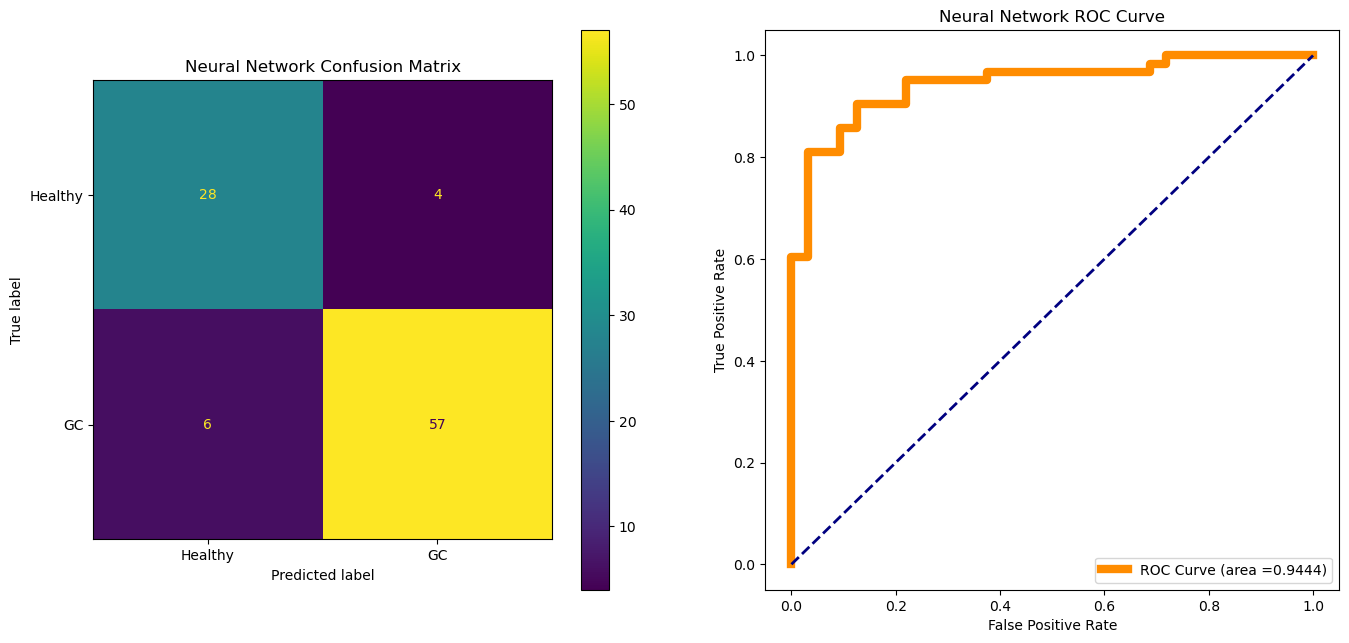

In [67]:
deep_model_validation('GC_Classifier_60pc_original_training.keras', X_external_pca, y_external)

Model: "sequential_218"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_908 (Dense)               │ (None, 200)            │         2,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_887 (Activation)     │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_909 (Dense)               │ (None, 700)            │       140,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_888 (Activation)     │ (None, 700)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_910 (Dense)               │ (None, 200)            │       140,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_889 (Activation)     │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_911 (Dense)               │ (None, 1)              │           201 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_890 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 849,905 (3.24 MB)

 Trainable params: 283,301 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 566,604 (2.16 MB)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9270 - loss: 0.6647      
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

Testing Data Performance
test accuracy: 0.8943662047386169
roc score: 0.9616578014184397


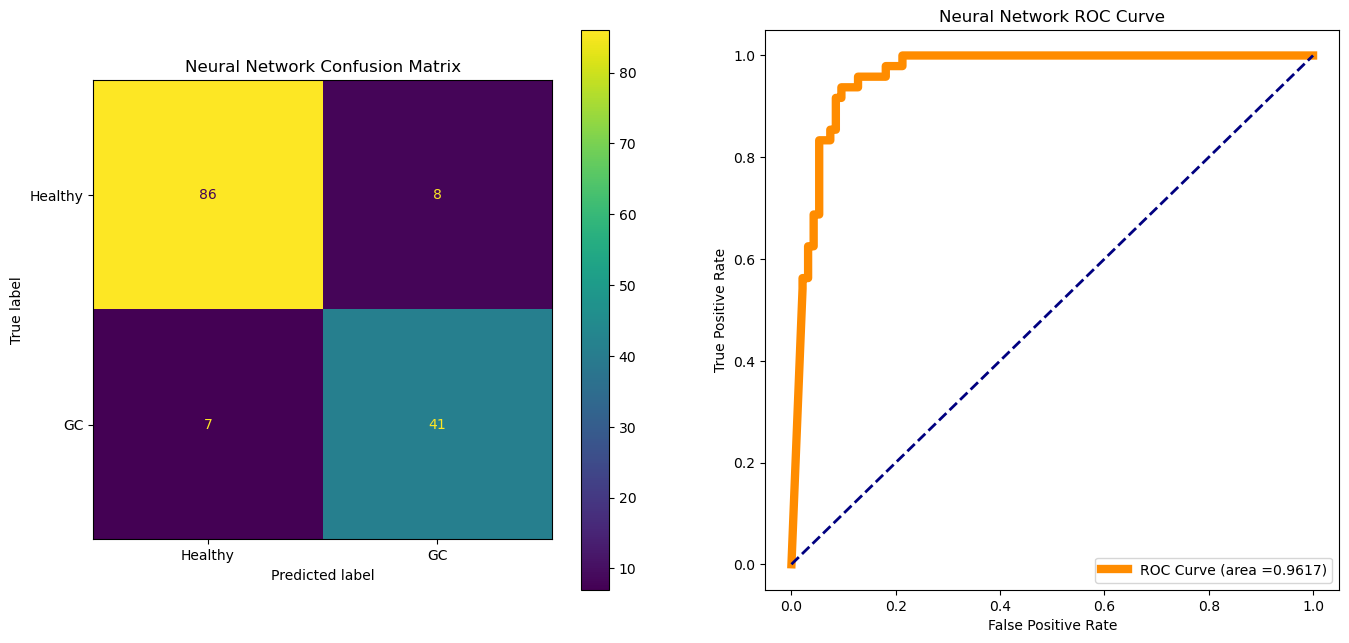

In [45]:
deep_model_validation('GC_Classifier_10dm.keras', X_test_10dm_scaled, y_test)

Model: "sequential_231"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_952 (Dense)               │ (None, 600)            │        88,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_931 (Activation)     │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_953 (Dense)               │ (None, 1)              │           601 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_932 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 268,205 (1.02 MB)

 Trainable params: 89,401 (349.22 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 178,804 (698.46 KB)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9733 - loss: 0.1407  
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

Testing Data Performance
test accuracy: 0.9577465057373047
roc score: 0.981604609929078


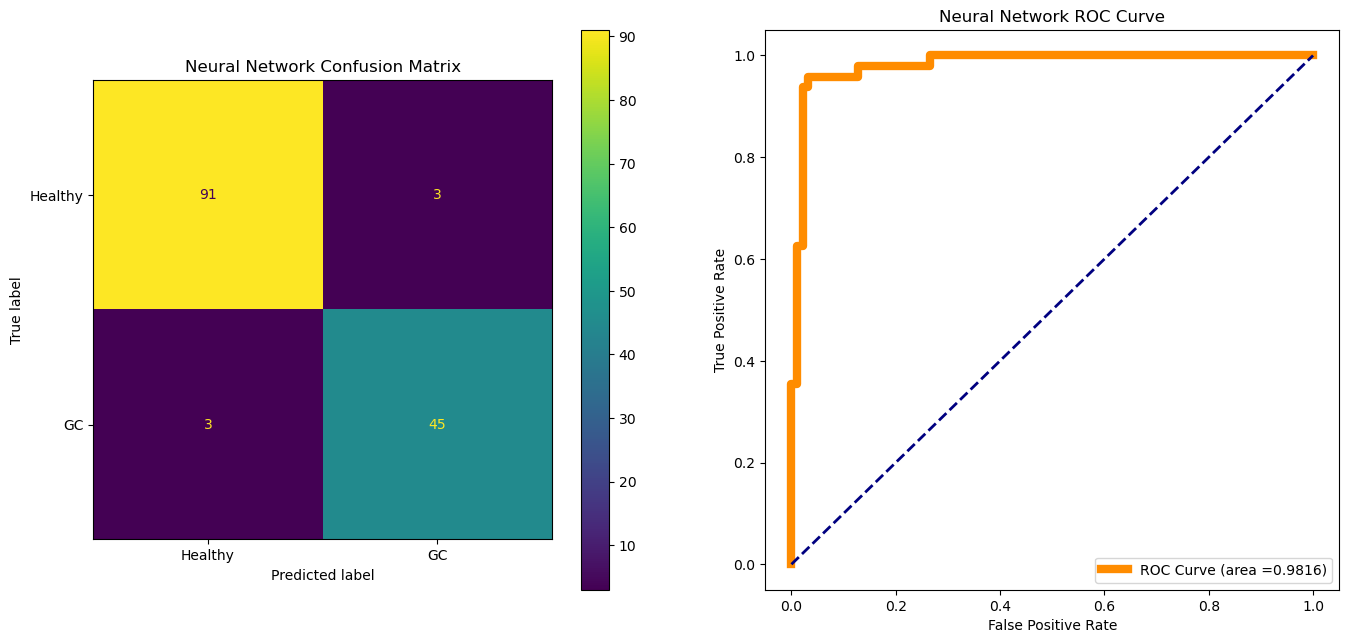

In [46]:
deep_model_validation('GC_Classifier_all_metabolites.keras', X_test_scaled, y_test)

Model: "sequential_242"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_984 (Dense)               │ (None, 1000)           │        61,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_963 (Activation)     │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_985 (Dense)               │ (None, 1)              │         1,001 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_964 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 186,005 (726.59 KB)

 Trainable params: 62,001 (242.19 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 124,004 (484.39 KB)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9733 - loss: 0.0866  
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

Testing Data Performance
test accuracy: 0.9577465057373047
roc score: 0.9884751773049645


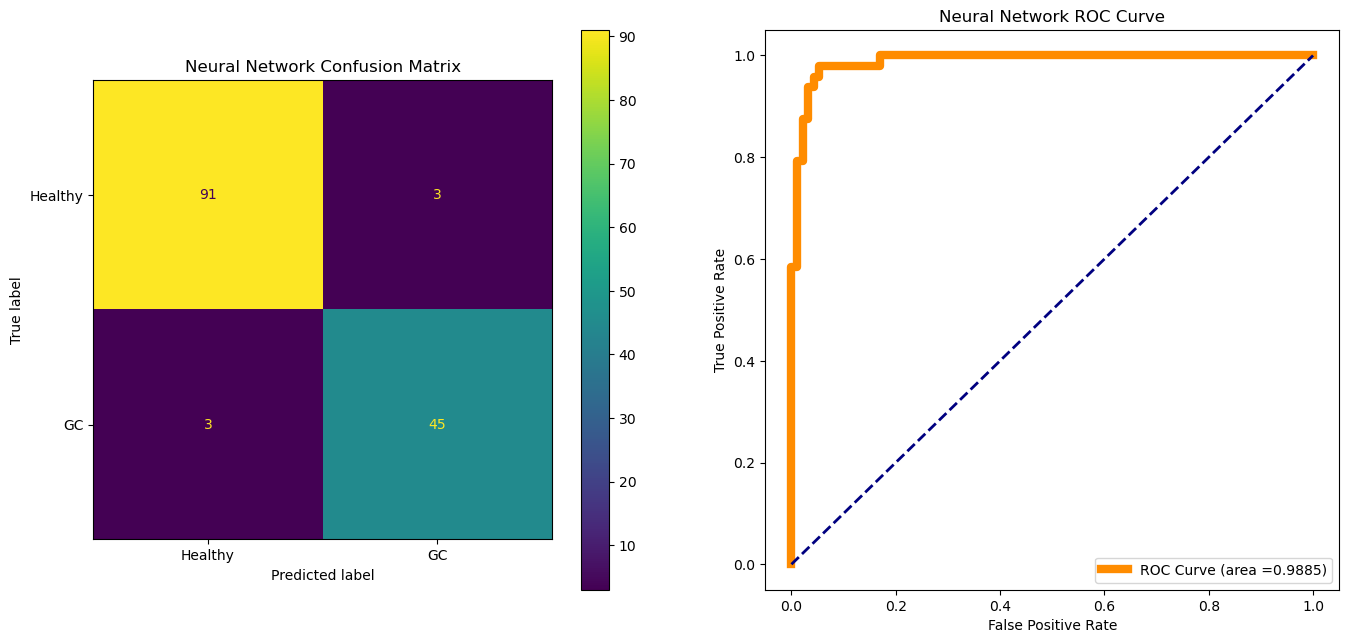

In [47]:
pca_model = PCA(n_components=60)
pca_model.fit(X_train_new_scaled) 
X_test_pca = pca_model.transform(X_test_scaled)
deep_model_validation('GC_Classifier_60pc.keras', X_test_pca, y_test)

# *Performance on Different Stages of Gastric Cancer* #

In [48]:
cohort_information = pd.read_excel('cohort_information.xlsx')
Xtrain = pd.read_excel('Xtrain.xlsx',index_col=0)
ytrain = pd.read_excel('ytrain.xlsx',index_col=0)
Xtest = pd.read_excel('Xtest.xlsx',index_col=0)
ytest = pd.read_excel('ytest.xlsx',index_col=0)
Xexternal = pd.read_excel('Xexternal_test.xlsx', index_col=0)
yexternal = pd.read_excel('yexternal_test.xlsx', index_col=0)

In [49]:
Xtrain_10dm = Xtrain[selected_features]
scaler_10dm = StandardScaler()
scaler_10dm.fit(Xtrain_10dm)
scaler_10dm.transform(Xtrain_10dm)
Xtest_10dm = Xtest[selected_features]
Xtest_10dm_scaled = scaler_10dm.transform(Xtest_10dm)

In [50]:
def assess_early_stage_accuracy(model, all_testing_data, model_testing_data, labels, neural_net=False):
    
    if neural_net == True:
        nn = load_model(model)
        predicted_scores = nn.predict(model_testing_data)
    else: 
        predicted_scores = model.predict_proba(model_testing_data)
        
    all_testing_data['state'] = labels['state']
    all_testing_data['pred_score'] = predicted_scores[:,-1]
    test = all_testing_data.merge(cohort_information[['sample_id', 'stage']], on='sample_id', how='left')
    test.loc[test['state'] == 0, 'stage'] = 'N'

    stage1A = test.loc[test['stage'] == 'IA', ['pred_score', 'state']]
    stage1A['predicted_state'] = (stage1A['pred_score'] >= 0.5).astype(int)
    stage1A['correct_prediction'] = (stage1A['predicted_state'] == stage1A['state'].astype(int))
    accuracy = stage1A['correct_prediction'].mean()
    print("Accuracy for stage 1A gastric cancer patients:", accuracy)

    stage1B = test.loc[test['stage'] == 'IB', ['pred_score', 'state']]
    stage1B['predicted_state'] = (stage1B['pred_score'] >= 0.5).astype(int)
    stage1B['correct_prediction'] = (stage1B['predicted_state'] == stage1B['state'].astype(int))
    accuracy = stage1B['correct_prediction'].mean()
    print("Accuracy for stage 1B gastric cancer patients:", accuracy)

    early_stage = test.loc[test['stage'].isin(['IA', 'IB', 'I', 'II']), ['pred_score', 'state']]
    early_stage['predicted_state'] = (early_stage['pred_score'] >= 0.5).astype(int)
    early_stage['correct_prediction'] = (early_stage['predicted_state'] == early_stage['state'].astype(int))
    accuracy = early_stage['correct_prediction'].mean()
    print("Accuracy for early stage gastric cancer patients:", accuracy)

    scaler = StandardScaler()
    test_scaled = scaler.fit_transform(test.iloc[:, :147])
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(test_scaled)
    pc_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
    pc_df['state'] = test['state'].astype(str)
    pc_df['sample_id'] = test['sample_id']
    
    # Prepare data for model performance validation plot
    model_performance = pd.merge(pc_df[['PC1', 'PC2', 'sample_id']], test[['sample_id', 'pred_score', 'state', 'stage']], on='sample_id')
    
    # Plot model performance prediction
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x='pred_score', y='PC1', hue='stage', data=model_performance)
    plt.axvline(x=0.5, color='red', linestyle='--')
    plt.xlabel('Predicted Value for GC')
    plt.ylabel('PC1 - {0:.2f}%'.format(pca.explained_variance_ratio_[0]*100))
    plt.title('Model Performance Prediction Test All Stage')
    plt.show()

# *Early Stage Performance for New Models* #

In [51]:
scaler_all = StandardScaler()
scaler_all.fit(X_train)
Xtrain_scaled = scaler_all.transform(X_train)
Xtest_scaled = scaler_all.transform(X_test)
Xexternal_scaled = scaler_all.transform(X_external)

scaler_10dm = StandardScaler()
scaler_10dm.fit(X_train_10dm)
Xtrain_10dm_scaled = scaler_10dm.transform(X_train_10dm)
Xtest_10dm_scaled = scaler_10dm.transform(X_test_10dm)
Xexternal_10dm_scaled = scaler_10dm.transform(X_external_10dm)

scaler_all_new = StandardScaler()
scaler_all_new.fit(X_train_new)
Xtrain_new_scaled = scaler_all_new.transform(X_train_new)
Xtest_new_scaled = scaler_all_new.transform(X_test)

scaler_10dm_new = StandardScaler()
scaler_10dm_new.fit(X_train_new_10dm)
Xtrain_new_10dm_scaled = scaler_10dm_new.transform(X_train_new_10dm)
Xtest_new_10dm_scaled = scaler_10dm_new.transform(X_test_10dm)

Accuracy for stage 1A gastric cancer patients: 0.875
Accuracy for stage 1B gastric cancer patients: 1.0
Accuracy for early stage gastric cancer patients: 0.8


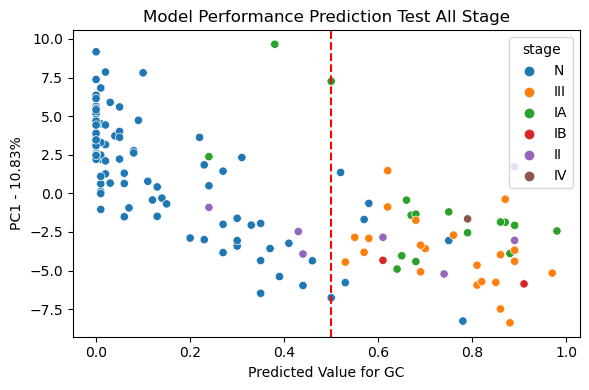

In [52]:
assess_early_stage_accuracy(original_model, Xtest, Xtest_10dm, y_test)

Accuracy for stage 1A gastric cancer patients: 0.9090909090909091
Accuracy for stage 1B gastric cancer patients: 0.75
Accuracy for early stage gastric cancer patients: 0.9310344827586207


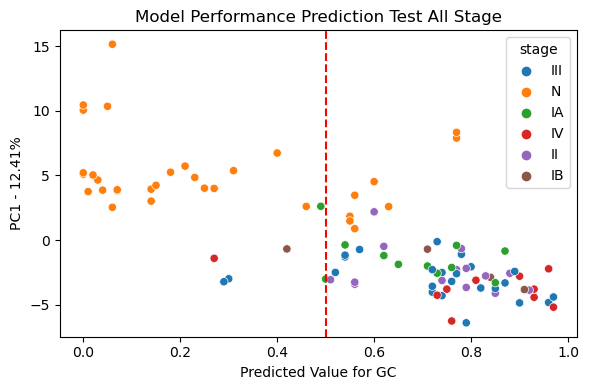

In [53]:
assess_early_stage_accuracy(original_model, Xexternal, X_external_10dm, y_external)

Accuracy for stage 1A gastric cancer patients: 0.875
Accuracy for stage 1B gastric cancer patients: 1.0
Accuracy for early stage gastric cancer patients: 0.8


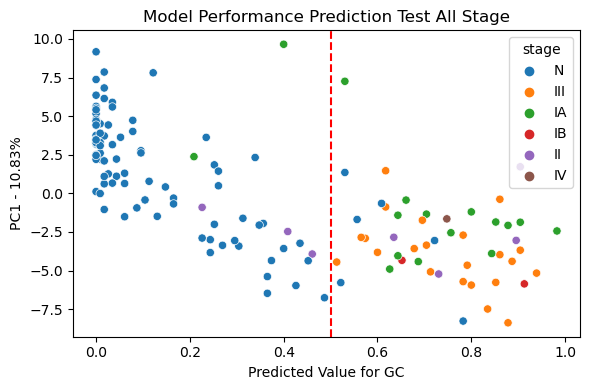

In [54]:
assess_early_stage_accuracy(best_rf, Xtest, Xtest_10dm_scaled, y_test)

Accuracy for stage 1A gastric cancer patients: 0.8181818181818182
Accuracy for stage 1B gastric cancer patients: 0.75
Accuracy for early stage gastric cancer patients: 0.896551724137931


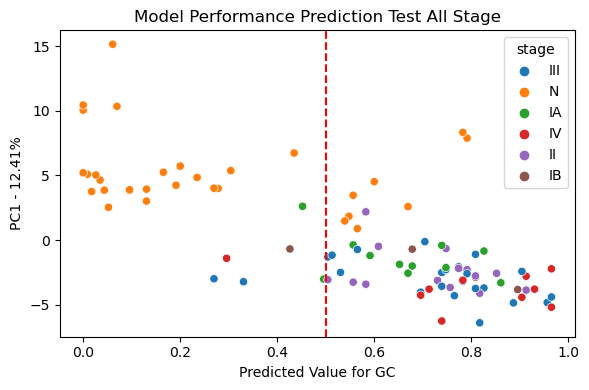

In [55]:
assess_early_stage_accuracy(best_rf, Xexternal, Xexternal_10dm_scaled, y_external)

Accuracy for stage 1A gastric cancer patients: 0.75
Accuracy for stage 1B gastric cancer patients: 1.0
Accuracy for early stage gastric cancer patients: 0.76


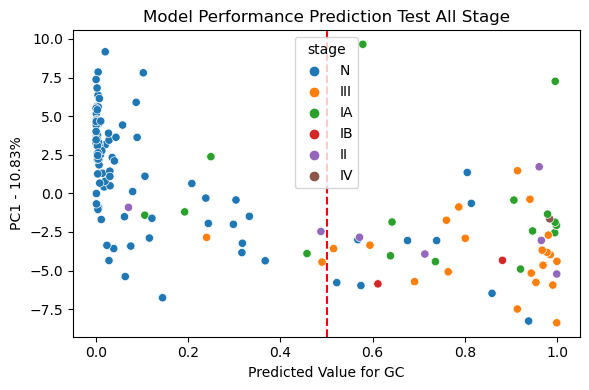

In [56]:
pca_model = PCA(n_components=19)
pca_model.fit(Xtrain_scaled) 
Xtest_pca = pca_model.transform(Xtest_scaled)
assess_early_stage_accuracy(log_reg_pca, Xtest, Xtest_pca, y_test)

Accuracy for stage 1A gastric cancer patients: 0.9090909090909091
Accuracy for stage 1B gastric cancer patients: 0.75
Accuracy for early stage gastric cancer patients: 0.896551724137931


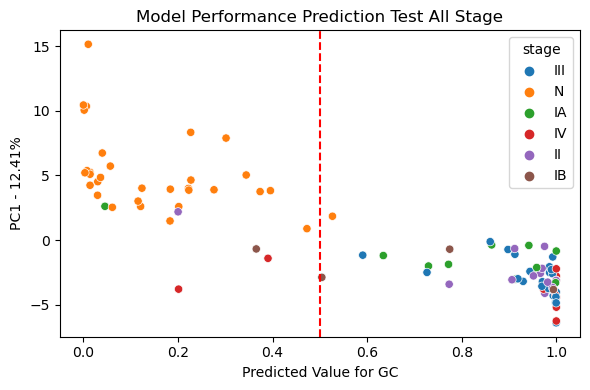

In [57]:
pca_model = PCA(n_components=19)
pca_model.fit(Xtrain_scaled) 
Xexternal_pca = pca_model.transform(Xexternal_scaled)
assess_early_stage_accuracy(log_reg_pca, Xexternal, Xexternal_pca, y_external)

Accuracy for stage 1A gastric cancer patients: 0.9375
Accuracy for stage 1B gastric cancer patients: 1.0
Accuracy for early stage gastric cancer patients: 0.92


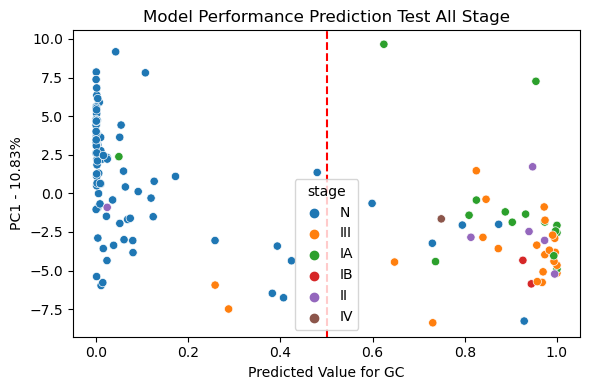

In [58]:
pca_model = PCA(n_components=75)
pca_model.fit(Xtrain_scaled) 
Xtest_pca = pca_model.transform(Xtest_scaled)
assess_early_stage_accuracy(svm_pca, Xtest, Xtest_pca, y_test)

Accuracy for stage 1A gastric cancer patients: 0.8181818181818182
Accuracy for stage 1B gastric cancer patients: 1.0
Accuracy for early stage gastric cancer patients: 0.896551724137931


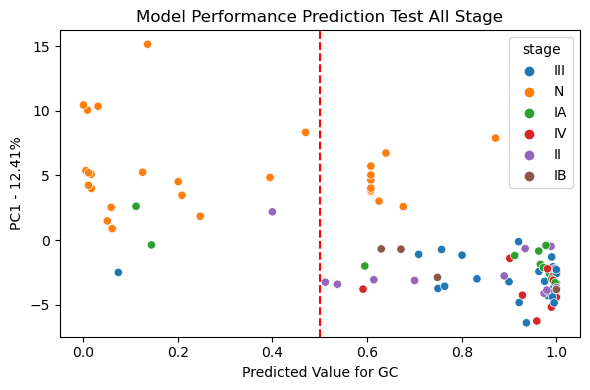

In [59]:
pca_model = PCA(n_components=75)
pca_model.fit(Xtrain_scaled) 
Xexternal_pca = pca_model.transform(Xexternal_scaled)
assess_early_stage_accuracy(svm_pca, Xexternal, Xexternal_pca, y_external)

# *Early Stage Performance of Neural Networks* #

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Accuracy for stage 1A gastric cancer patients: 0.8125
Accuracy for stage 1B gastric cancer patients: 1.0
Accuracy for early stage gastric cancer patients: 0.84


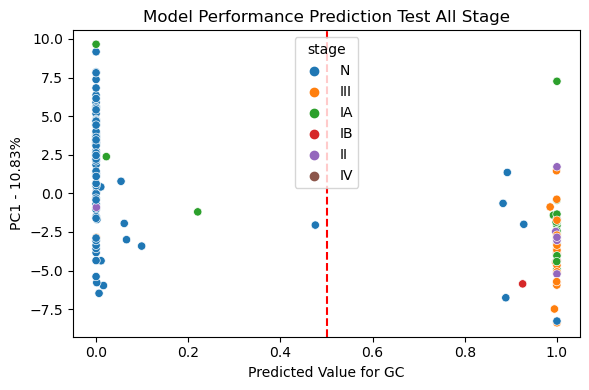

In [60]:
pca_model = PCA(n_components=60)
pca_model.fit(Xtrain_scaled) 
Xtest_pca = pca_model.transform(Xtest_scaled)
assess_early_stage_accuracy('GC_Classifier_60pc_original_training.keras', Xtest, Xtest_pca, y_test, neural_net=True)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Accuracy for stage 1A gastric cancer patients: 0.8181818181818182
Accuracy for stage 1B gastric cancer patients: 0.75
Accuracy for early stage gastric cancer patients: 0.8620689655172413


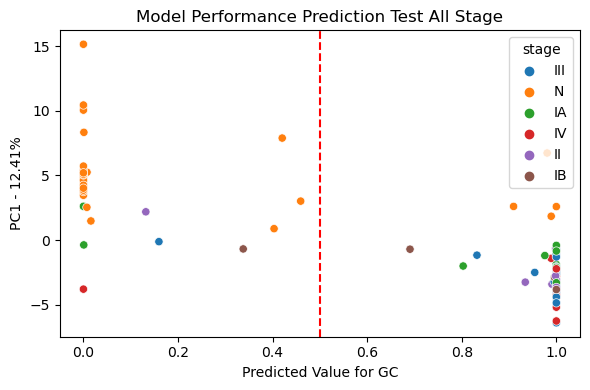

In [61]:
pca_model = PCA(n_components=60)
pca_model.fit(Xtrain_scaled) 
Xexternal_pca = pca_model.transform(Xexternal_scaled)
assess_early_stage_accuracy('GC_Classifier_60pc_original_training.keras', Xexternal, Xexternal_pca, y_external, neural_net=True)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Accuracy for stage 1A gastric cancer patients: 0.9375
Accuracy for stage 1B gastric cancer patients: 1.0
Accuracy for early stage gastric cancer patients: 0.92


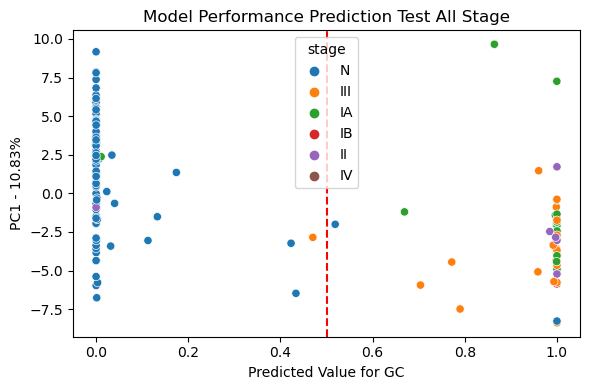

In [62]:
assess_early_stage_accuracy('GC_Classifier_all_metabolites.keras', Xtest, Xtest_new_scaled, y_test, neural_net=True)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Accuracy for stage 1A gastric cancer patients: 1.0
Accuracy for stage 1B gastric cancer patients: 1.0
Accuracy for early stage gastric cancer patients: 0.96


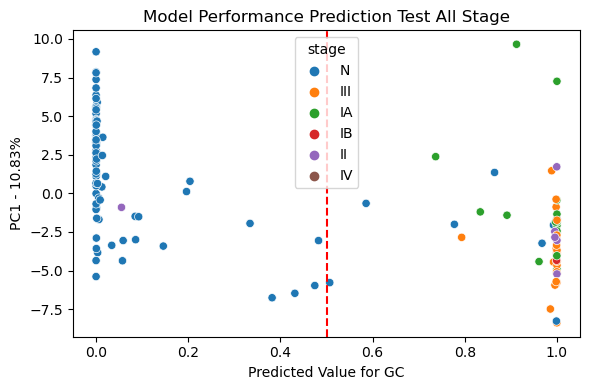

In [63]:
pca_model = PCA(n_components=60)
pca_model.fit(Xtrain_new_scaled) 
Xtest_pca = pca_model.transform(Xtest_scaled)
assess_early_stage_accuracy('GC_Classifier_60pc.keras', Xtest, Xtest_pca, y_test, neural_net=True)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Accuracy for stage 1A gastric cancer patients: 0.875
Accuracy for stage 1B gastric cancer patients: 1.0
Accuracy for early stage gastric cancer patients: 0.84


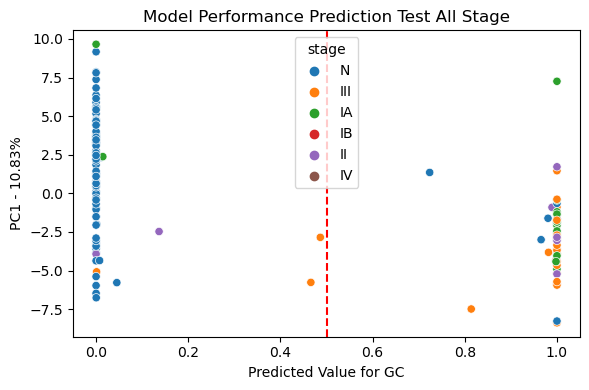

In [64]:
assess_early_stage_accuracy('GC_Classifier_10dm.keras', Xtest, Xtest_new_10dm_scaled, y_test, neural_net=True)